# Data

To fetch the data we created a repository that housed a script that fetches the data.<br>
The link to the repository can be found here : <br>
https://github.com/sirandreww/operate_first_prometheus_data.git

We have added more information about what data is being fetched and how in that repository.
The main point being that the data we are pulling is:

## How is data fetched and processed?

1. Memory-usage data for each container using this Prometheus query `sum(container_memory_working_set_bytes{name!~".*prometheus.*", image!="", container!="POD", cluster="moc/smaug"}) by (container, pod, namespace, node)`.
   
2. CPU-usage data for each container using this Prometheus query `sum(rate(container_cpu_usage_seconds_total{name!~".*prometheus.*", image!="", container!="POD", cluster="moc/smaug"}[5m])) by (container, pod, namespace, node)`.
   
3. Memory-usage percentage data for each node using this Prometheus query `node_memory_Active_bytes/node_memory_MemTotal_bytes*100`.

After the data is fetched, it gets compiled into csv files that describe each hour as shown in the image bellow:

<div>
    <img src="images/data_step1.png" width="800"/>
</div>

After the data was fetched on a daily basis for a few months, we needed a way to merge all this data into larger time spans. This is why we created a script that merges the data, the script is designed to merge the data into as few files as it can, depending on the amount of memory the system it is running on has. The scripts takes two csv files, merges them using an outer join (similar to outer join of SQL) then writes the out come to another folder. For example, if we start with 8 files, after the first iteration we would have 4 file, each of them describing a span of 2 hours. After the second iteration we would have 2 csv files each descrdescribing 4 hours, and so on. This design choice was chosen after a few failed attempts with other methods which either resulted in files not being with a uniform size or the script running out of memory before terminating. For an example at what such a script would output take a look at these images:

<div>
    <img src="images/data_step2_img1.png" width="800"/>
</div>

<div>
    <img src="images/data_step2_img2.png" width="800"/>
</div>

Even after we have merged all the csv files, they still would require much preprocessing before any serious machine learning can be done on them. To make it easier to work with the data we have also made a script that takes these csv files and organizes them in json files. Each application will have multiple time series that were captured for it, this is how we deal with missing values. By turning one time series with missing values into multiple time series with no missing values we take most of the guess work out of dealing with missing values. The script takes csv file from the previous part and turns them into json files, refer to the images bellow for reference.

<div>
    <img src="images/data_step3_img1.png" width="800"/>
</div>

<div>
    <img src="images/data_step3_img2.png" width="800"/>
</div>

<div>
    <img src="images/data_step3_img3.png" width="800"/>
</div>

This is all that is being done by the previously mentioned data fetching repository. Again the link to it can be found here:

https://github.com/sirandreww/operate_first_prometheus_data.git

After that these json files are copied and put into the file `jupyter_notebooks/data/` in this repository.
The python libraries in this repository know how to deal with data in this format.

## Plotting data

We have made a function that takes two main inputs (it also takes a third but that is only to ease implementation). The first input is `metric` which can be one of 3 things really, either container memory, container cpu, or node memory, notice that these are present in the names of the json files. The second input is `application_name` which is some application that we're interested in data usage for. Form these 2 inputs it goes over all the relevant json files, and take the data that belongs to that app in each one. The function returns a dataset object, which is a glorified list of pandas dataframes with two columns, one for time and one for the sample. Let's take a look at some data.

In [1]:
import src.framework__data_set as ds

Getting the dataset for container memory data, for the cointainer bridge-marker.

In [2]:
dataset = ds.get_data_set(
    metric="container_mem",
    application_name="bridge-marker",
    path_to_data="./data/"
)

Now let's plot some samples in the data to get a visual on what we're looking at.

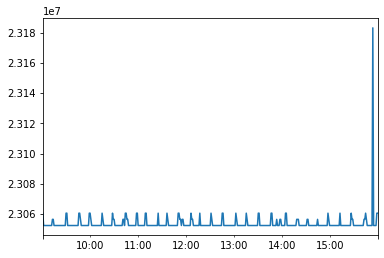

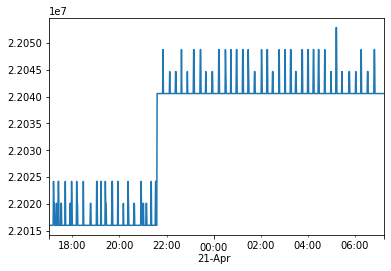

In [3]:
dataset.plot_dataset(number_of_samples=2)

As you can see the data for each application is split to many time series. Each one is continous and without any "interruptions" in the middle.

## What Applications Will We Consider?

As for the applications we're going to be learning on, let's take a look at the applications with the most data for each metric.

First let's take a look at node memory usage data:

In [4]:
hist = ds.get_amount_of_data_per_application(
    metric="node_mem",
    path_to_data="./data/"
)
print(hist[:10])

[('moc/smaug', 313820), ('emea/balrog', 72447), ('emea/rick', 54929), ('moc/infra', 25405)]


We'll look at the following nodes:
1. moc/smaug
2. emea/balrog

Now let's take a look at container memory usage data:

In [5]:
hist = ds.get_amount_of_data_per_application(
    metric="container_mem",
    path_to_data="./data/"
)
print(hist[:10])

[('kube-rbac-proxy', 7718487), ('cni-plugins', 3142572), ('driver-registrar', 2820695), ('oauth-proxy', 1942223), ('collector', 1701727), ('nmstate-handler', 1587755), ('keepalived', 1587373), ('node-exporter', 1586814), ('coredns', 1586715), ('whereabouts-cni-bincopy', 1586041)]


We'll look at the following applications:
1. nmstate-handler
2. coredns
3. keepalived

Now let's take a look at container cpu usage data:

In [6]:
hist = ds.get_amount_of_data_per_application(
    metric="container_cpu",
    path_to_data="./data/"
)
print(hist[:10])

[('kube-rbac-proxy', 7578821), ('oauth-proxy', 1885203), ('collector', 1602125), ('coredns-monitor', 1564425), ('network-metrics-daemon', 1559549), ('nmstate-handler', 1556575), ('dns-node-resolver', 1554940), ('dns', 1554337), ('node-ca', 1552028), ('kube-multus-additional-cni-plugins', 1549615)]


We'll look at the following applications:
1. kube-rbac-proxy
2. dns
3. collector

## How Is Data Pre-Processed?

In [7]:
dataset = ds.get_data_set(
    metric="container_cpu",
    application_name="dns",
    path_to_data="./data/"
)

Plot the data of this data set:

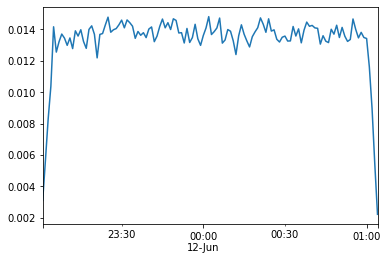

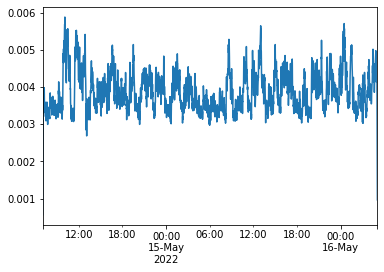

In [8]:
dataset.plot_dataset(number_of_samples=2)

As we can see, we have a sample for each minute, we can further subsample the data to get data that is easier to generalize. Here we change the dataset so it is has samples 5 minutes appart:

In [9]:
dataset.sub_sample_data(sub_sample_rate=5)

Dropping series that are shorter than 10 sample long (less than 5 * 10 minutes long)

In [10]:
print("Data set size before:", len(dataset))
dataset.filter_data_that_is_too_short(data_length_limit=10)
print("Data set size after:", len(dataset))

Data set size before: 2991
Data set size after: 2968


Let's plot again to see how the samples look now.

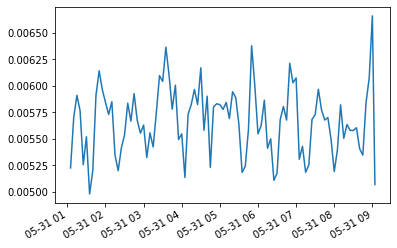

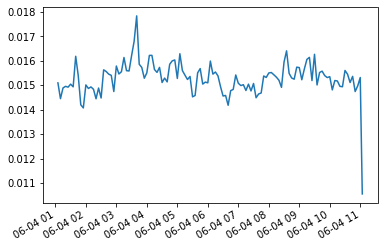

In [11]:
dataset.plot_dataset(number_of_samples=2)

The data is highly variable and is not scaled, let's scale it.

In [12]:
dataset.scale_data()

Let's plot again to see how the samples look now.

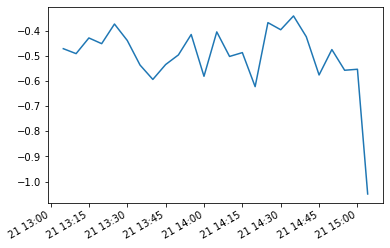

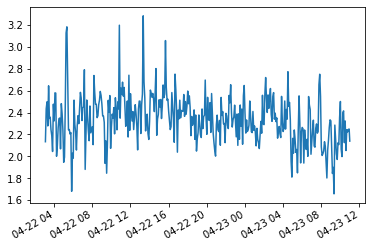

In [13]:
dataset.plot_dataset(number_of_samples=2)

Now we can split the data into train and test. The splitting is done by taking out `length_to_predict` from each time series and making that the training set. This was done in order to simulate the real world scenario where one would have the beginning of all the time series (all the data up until a certain time) and would need to predict the future `length_to_predict` number of samples.

In [14]:
train, test = dataset.split_to_train_and_test(length_to_predict=5)
print(f"Amount of train data is {len(train)}")
print(f"Amount of test data is  {len(test)}")
print(f"Length of first time series in train is {len(train[0])}")
print(f"Length of first time series in test is  {len(test[0])}")

Amount of train data is 2968
Amount of test data is  2968
Length of first time series in train is 67
Length of first time series in test is  72


This is the preprocessing that is done to the data each time we use it for trainning.